The experiment consisted of running the non-large (excluding Trove with s=5 and 2D stencil with k=5) matrix multiplication (the single thread algorithm) and to parallelize the computation of each row of the output (the row parallelism case).

Code-wise, this was effectively putting some mutexes in and replacing a for loop with a parallel iterator.

In [1]:
# initial setup
import sys
sys.path.append("../analysis")

In [2]:
import parsing
import extraction
import timing
import utils

from extraction import pull_spec_in
from utils import fetch

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
%matplotlib inline

In [5]:
single_thread_raw = fetch("2020-05-13-single-thread-multiplies")
parallel_row_raw = fetch("2020-05-13-parallel-row-multiplies")

In [6]:
single_thread_all_data = pull_spec_in(extraction.matrix_stats(single_thread_raw))
parallel_row_all_data = pull_spec_in(extraction.matrix_stats(parallel_row_raw))

single_thread_times = single_thread_all_data[
    single_thread_all_data['category'] == 'mul']\
    .set_index('key')[["spec", "time"]]
parallel_row_times = parallel_row_all_data[
    parallel_row_all_data['category'] == 'mul']\
    .set_index('key')[["spec", "time"]]

In [7]:
parallel_row_time = parallel_row_times['time'].copy()
parallel_row_time.name = "Parallel row time"
single_thread_time = single_thread_times['time'].copy()
single_thread_time.name = "Single_thread time"

In [8]:
time_table = pd.concat([single_thread_time, parallel_row_time], axis=1)
time_table

,Single_thread time,Parallel row time
key,,
"matrices/32-cond_keep_32,3-col_rots_no_group-32,3",0.558105,0.660212
"matrices/32-cond_keep_32,3-col_rots_no_group_32,3-col_xforms_no_group-32,3",2.884433,7.081888
"matrices/4,4-identity_4,4,3,3-2s-rnc{main[1]out[1]second[3]}-4,4,3,3",2.525692,2.934755
"matrices/4,4-identity_4,4,3,3-2s-rnc{main[1]out[1]second[3]}_4,4,3,3-2s-xfnc{main[1]out[1]second[3]}-4,4,3,3",7.446618,6.496716
"matrices/4,4-identity_4,4,3,3-2s-rnc{main[1]out[1]second[3]}_4,4,3,3-2s-xfnc{main[1]out[1]second[3]}_4,4,3,3-2s-rnc{main[0]out[0]second[2]}-4,4,3,3",3.435772,5.590158
...,...,...
"matrices/32-col_rots_no_group_32,5-col_xforms_no_group_32,5-row_rots_no_group-32,5",6.053254,15.749043
"matrices/32,2-row_rots_no_group_32,2-row_xforms_no_group-32,2",0.302326,0.296427
"matrices/32,2-row_rots_no_group_32,2-row_xforms_no_group_32,2-col_rots_no_group-32,2",0.435595,0.413458


In [9]:
speedup = single_thread_time / parallel_row_time
speedup.name = "Speedup"
speedup

key
matrices/32-cond_keep_32,3-col_rots_no_group-32,3                                                                                                      0.845342
matrices/32-cond_keep_32,3-col_rots_no_group_32,3-col_xforms_no_group-32,3                                                                             0.407297
matrices/4,4-identity_4,4,3,3-2s-rnc{main[1]out[1]second[3]}-4,4,3,3                                                                                   0.860614
matrices/4,4-identity_4,4,3,3-2s-rnc{main[1]out[1]second[3]}_4,4,3,3-2s-xfnc{main[1]out[1]second[3]}-4,4,3,3                                           1.146213
matrices/4,4-identity_4,4,3,3-2s-rnc{main[1]out[1]second[3]}_4,4,3,3-2s-xfnc{main[1]out[1]second[3]}_4,4,3,3-2s-rnc{main[0]out[0]second[2]}-4,4,3,3    0.614611
                                                                                                                                                         ...   
matrices/32-col_rots_no_group_32,5-c

In [10]:
speedup.mean()

0.5572549309013302

Interestingly, we can see that (unless I screwed up the experiments somehow), this parallelization strategy actually makes the multiplication *slower* on average.

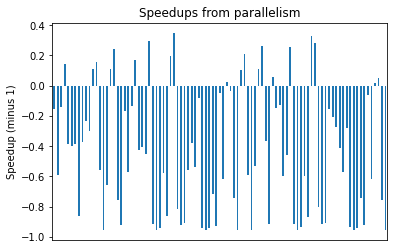

In [11]:
ax = (speedup.reset_index()['Speedup'] - 1)\
.plot(kind='bar', use_index=False)
ax.set_ylabel("Speedup (minus 1)")
ax.set_xticks([])
ax.set_title("Speedups from parallelism")
None

My initial thought on the problem here is that this parallelism strategy (computing the rows in parallel, with work-stealing) just increases the memory bottlenecks in this algorith (which already involves a lot of random memory access). Hyperthreading (if it's getting involved) might not be helping here.

It's also possible that the overhead of spawning threads isn't worth it in most cases, maybe because each individual row is so fast to compute.

More experiments are needed to find a parallelization strategy that works.

Initial thoughts include:
* Batches of rows as one work unit
* Parallelizing the part of the algorithm that scans through the matrix for an intersection after the vector of 1s in a row of $a$ has been computed
* Searching for or devising algorithms that allow for tiling (there's  a Four Russians' algorithm that might parallelize better)

In [12]:
time_table['Speedup'] = speedup

In [13]:
time_table.to_csv('../results/2020-05-13-row-parallelism-times.csv')